In [1]:
import pandas as pd
import numpy as np
from numpy import save, load
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

import time

In [217]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 200)

In [3]:
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
import seaborn as sns

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline

## 1a) Read in and Process the Ratings Data

In [280]:
ratings = pd.read_csv('datasets/ratings.csv').drop(columns='timestamp')

print(ratings.info())
print(ratings.shape)
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10747027 entries, 0 to 10747026
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 246.0 MB
None
(10747027, 3)


,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [281]:
ratings['userId'].unique().shape

(110490,)

In [282]:
ratings['movieId'].unique().shape

(41688,)

#### Read in the TMDB Titles Data:

In [283]:
movies = pd.read_csv('final_dataset.csv', lineterminator='\n', index_col=0)[['movieId', 'title']]
print(movies.shape)
movies.head()

(47723, 2)


,movieId,title
0,1,Toy Story
1,2,Jumanji
2,3,Grumpier Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


Because movies were dropped from the movies dataset above, we have to make sure none of those dropped movies are in the ratings data:

In [284]:
ratings['movieId'].unique().shape

(41688,)

In [285]:
common_movie_ids = np.intersect1d(ratings['movieId'].unique(), movies['movieId'].unique())
common_movie_ids.shape

(35579,)

In [286]:
## Judging by the reduced number of common_movie_ids, it looks like this step was definitely justified!

print(ratings.shape)
ratings = ratings[ratings['movieId'].isin(common_movie_ids)]
print(ratings.shape)

(10747027, 3)
(10650036, 3)


In [287]:
ratings['userId'].unique().shape

(110462,)

In [288]:
ratings['userId'].describe()

count    1.065004e+07
mean     5.526870e+04
std      3.199252e+04
min      1.000000e+00
25%      2.773900e+04
50%      5.528400e+04
75%      8.292200e+04
max      1.104900e+05
Name: userId, dtype: float64

In [289]:
ratings_count_df = ratings.groupby('userId')['rating'].count().reset_index()
ratings_count_df.columns = ['userId', 'num_ratings']
ratings_count_df
ratings_count_df['num_ratings'].describe()

count    110462.000000
mean         96.413572
std         201.402815
min           1.000000
25%          15.000000
50%          30.000000
75%          93.000000
max        6289.000000
Name: num_ratings, dtype: float64

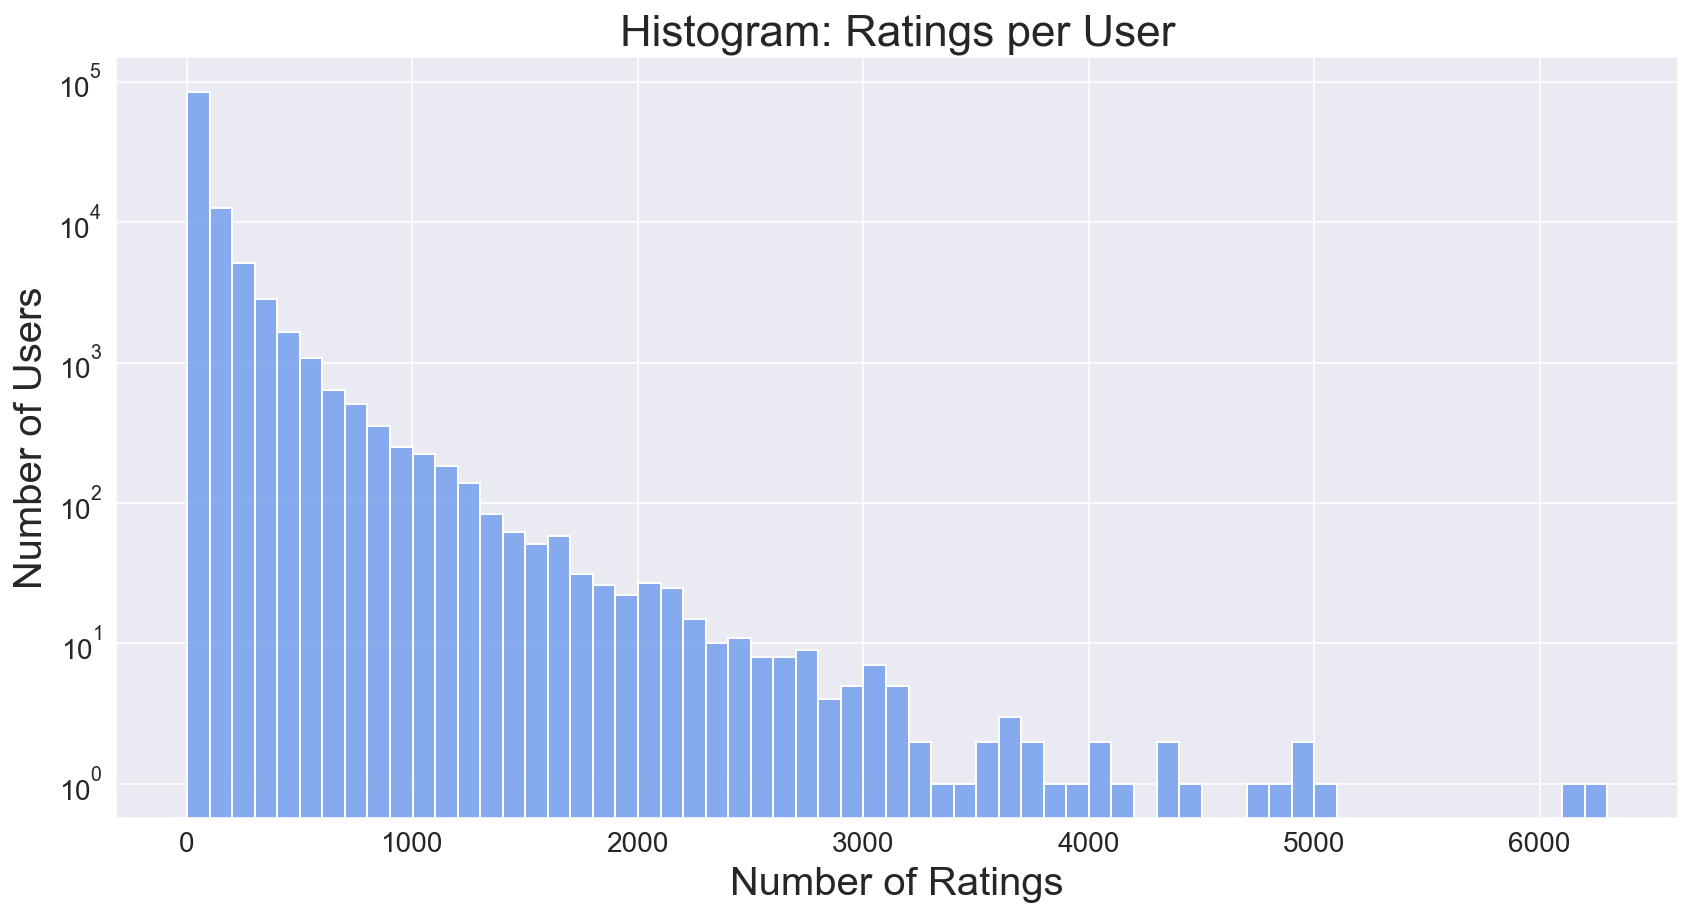

In [290]:
sns.set_style('darkgrid')
plt.figure(figsize=(14,7))
sns.histplot(ratings_count_df['num_ratings'], binwidth=100, color='cornflowerblue', edgecolor='w', linewidth=1)
plt.title('Histogram: Ratings per User', size=22)
plt.xticks(size=14)
# plt.xlim([0, 26])
plt.xlabel('Number of Ratings', size=20)
plt.yticks(size=14)
plt.ylabel('Number of Users', size=20)
plt.yscale('log');

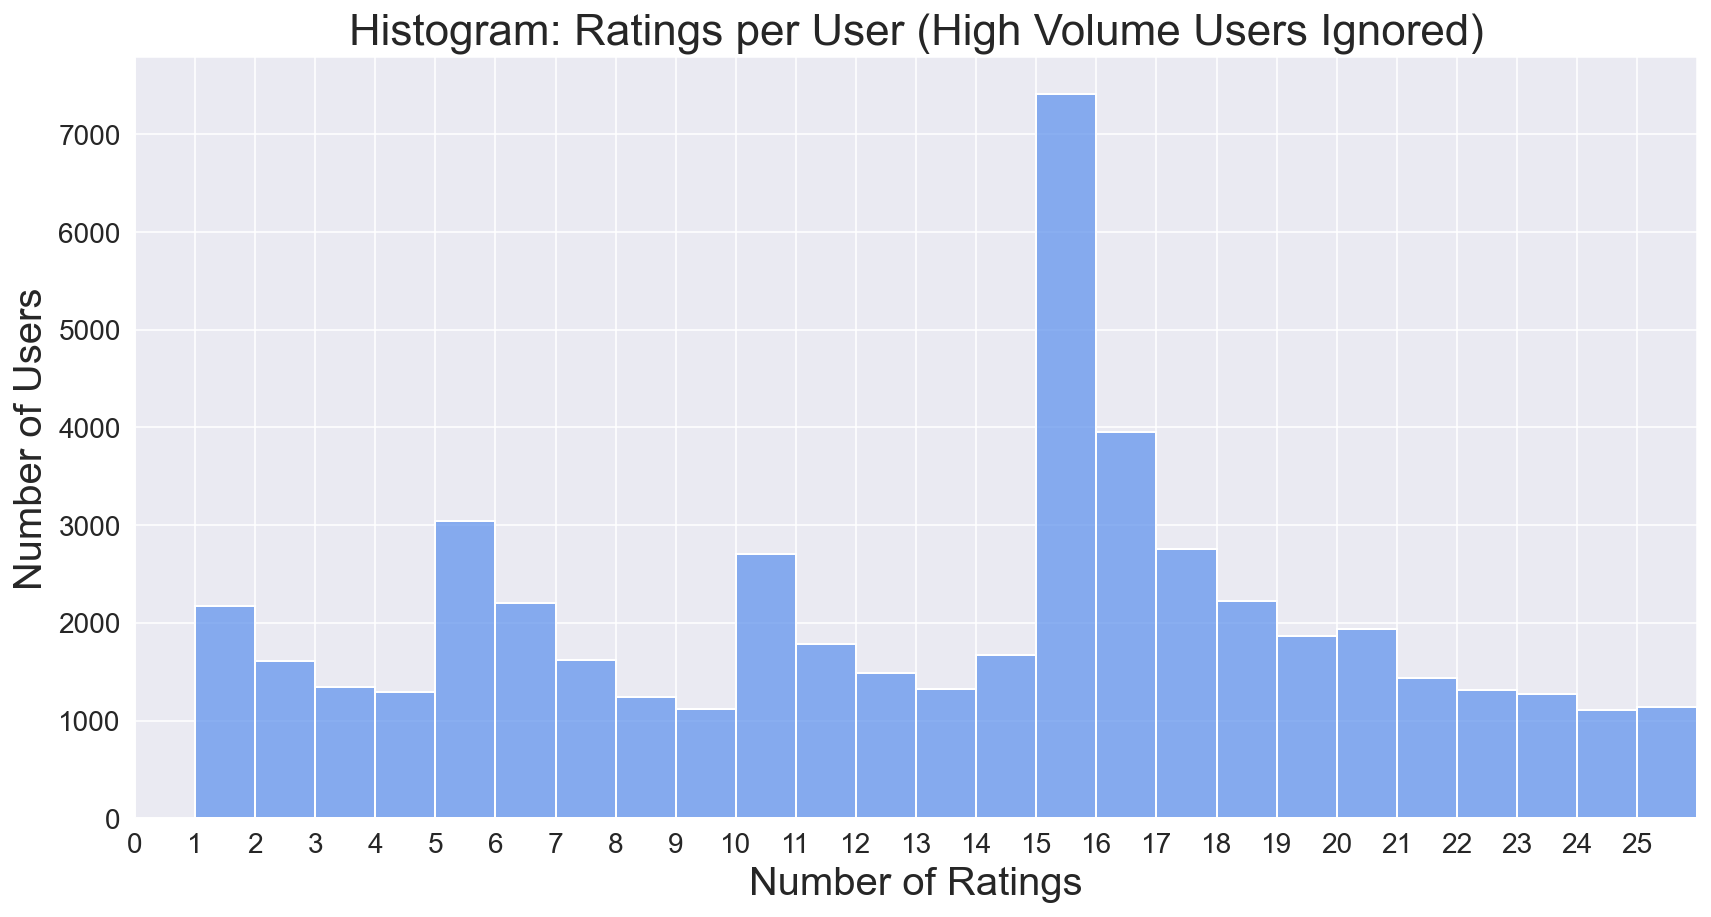

In [291]:
plt.figure(figsize=(14,7))
sns.histplot(ratings_count_df['num_ratings'], binwidth=1, color='cornflowerblue', edgecolor='w', linewidth=1)
plt.title('Histogram: Ratings per User (High Volume Users Ignored)', size=22)
plt.xticks(np.arange(0, 26, 1), size=14)
plt.xlim([0, 26])
plt.xlabel('Number of Ratings', size=20)
plt.yticks(size=14)
plt.ylabel('Number of Users', size=20);

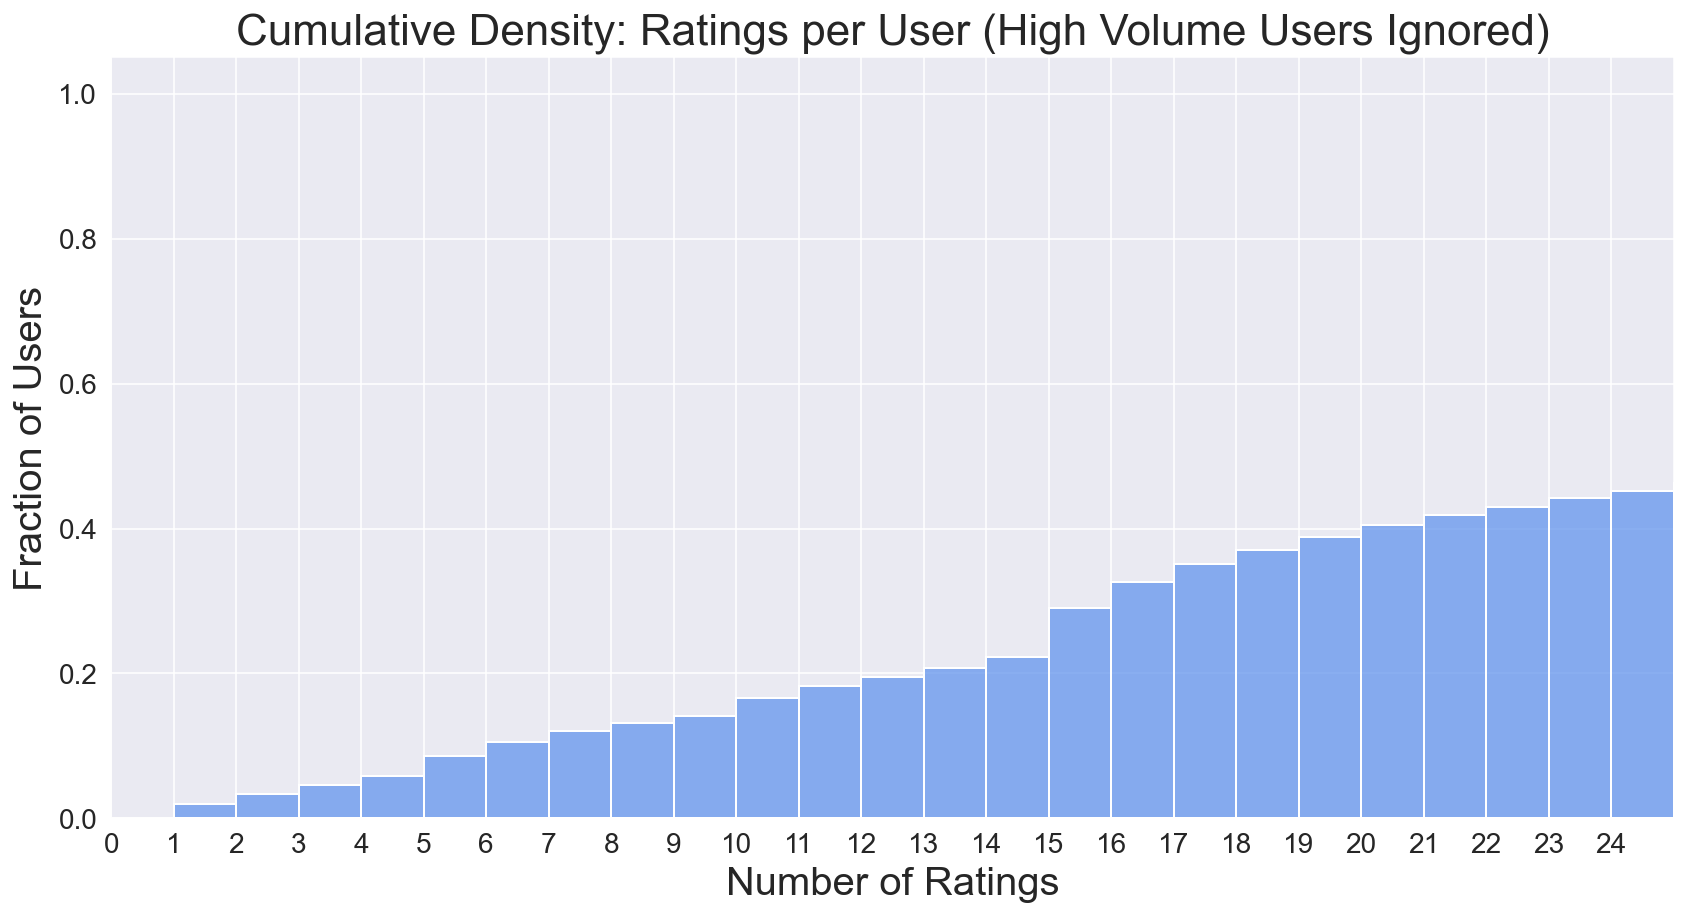

In [292]:
plt.figure(figsize=(14,7))
sns.histplot(ratings_count_df['num_ratings'], binwidth=1, color='cornflowerblue', 
             edgecolor='w', linewidth=1, cumulative=True, stat='density')
plt.title('Cumulative Density: Ratings per User (High Volume Users Ignored)', size=22)
plt.xticks(np.arange(0, 25, 1), size=14)
plt.xlim([0, 25])
plt.xlabel('Number of Ratings', size=20)
plt.yticks(size=14)
plt.ylabel('Fraction of Users', size=20);

### Design Decision:
1) Recommendations will only be made for users with at least 5 ratings that OVERLAP with another user having > 5 ratings (based on the assumption that user-similarity really cannot be established reasonably well with fewer than 5 rated movies to compare).

2) Note that any prospective "similar user" must have rated AT LEAST 1 movie that does not overlap with the current user's rated movies

In [293]:
users_5plus_ratings = ratings_count_df[~(ratings_count_df['num_ratings'] < 5)]['userId']
# save('users_5plus_ratings.npy', users_5plus_ratings)

users_under5_ratings = ratings_count_df[(ratings_count_df['num_ratings'] < 5)]['userId']
# save('users_under5_ratings.npy', users_under5_ratings)

In [294]:
## Way too much data to work with; start by removing the "under 5 ratings" users' data

ratings = ratings[ratings['userId'].isin(users_5plus_ratings)]
ratings.shape

(10635447, 3)

In [295]:
## Still way too much data (workbook runs out of memory) - randomly sample down to just 50,000 users

np.random.seed(42)

print(users_5plus_ratings.shape)
users_5plus_ratings = np.random.choice(users_5plus_ratings, size=50000, replace=False)
print(users_5plus_ratings.shape)

(104043,)
(50000,)


In [296]:
# save('users_5plus_ratings.npy', users_5plus_ratings)

In [297]:
print(ratings.shape)
ratings = ratings[ratings['userId'].isin(users_5plus_ratings)]
print(ratings.shape)

(10635447, 3)
(5004591, 3)


In [298]:
ratings['userId'].unique().shape

(50000,)

In [299]:
ratings['movieId'].unique().shape

(28044,)

In [300]:
# Clearly, all ratings are > 0; so we can use a rating of 0 to denote "User has not rated this movie"

ratings['rating'].value_counts()

4.0    1347185
3.0     994703
5.0     741581
3.5     603843
4.5     425080
2.0     333816
2.5     239742
1.0     160825
0.5      79449
1.5      78367
Name: rating, dtype: int64

In [301]:
ratings['userId'].value_counts(ascending=True)

44276        5
105056       5
5273         5
65064        5
105065       5
          ... 
67625     3746
61614     4024
105104    4309
60950     4382
94843     4965
Name: userId, Length: 50000, dtype: int64

In [302]:
ratings.head()

,userId,movieId,rating
16,2,170,3.5
17,2,849,3.5
18,2,1186,3.5
19,2,1235,3.0
20,2,1244,3.0


#### Update the ratings_count_df to reflect the filtered-down to 50,000 users dataset:

In [303]:
print(ratings_count_df.shape)
ratings_count_df = ratings_count_df[ratings_count_df['userId'].isin(users_5plus_ratings)]
print(ratings_count_df.shape)

(110462, 2)
(50000, 2)


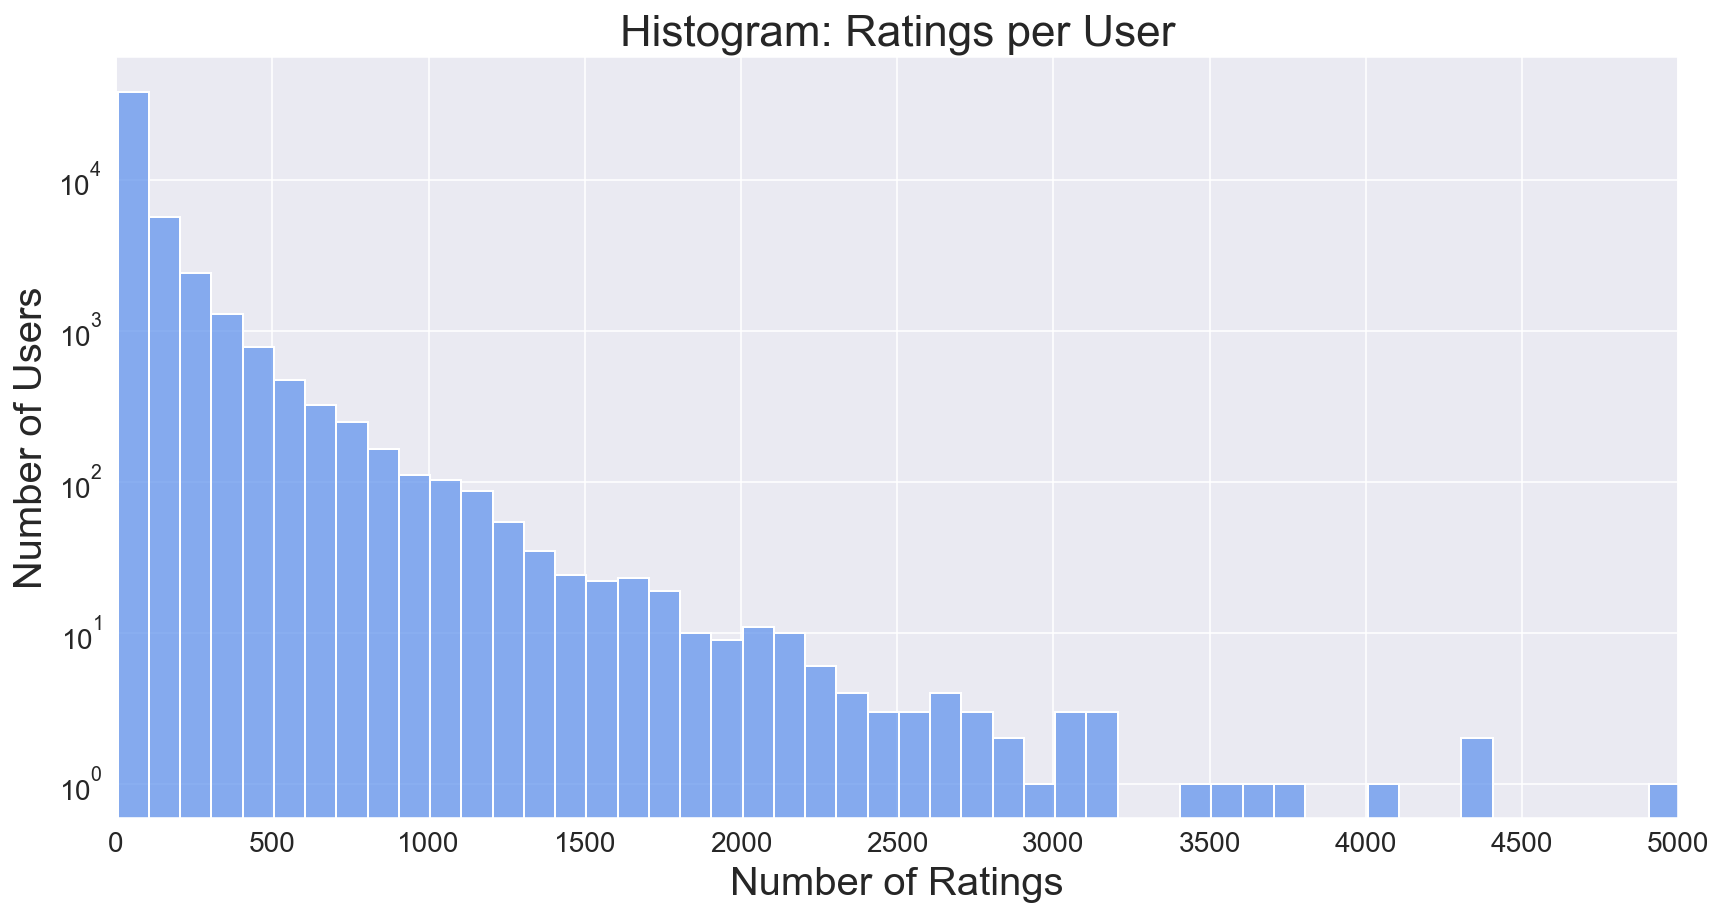

In [327]:
plt.figure(figsize=(14,7))
sns.histplot(ratings_count_df['num_ratings'], binwidth=100, color='cornflowerblue', edgecolor='w', linewidth=1)
plt.title('Histogram: Ratings per User', size=22)
plt.xticks(np.arange(0, 5001, 500), size=14)
plt.xlim([0, 5000])
plt.xlabel('Number of Ratings', size=20)
plt.yticks(size=14)
plt.ylabel('Number of Users', size=20)
plt.yscale('log');

## 2) Create a Users-Ratings Matrix

In [26]:
users_ratings_matrix = pd.DataFrame(data=np.zeros(shape=(ratings['userId'].unique().shape[0],
                                                         ratings['movieId'].unique().shape[0])),
                                    index=ratings['userId'].unique(),
                                    columns=ratings['movieId'].unique())

print(users_ratings_matrix.shape)
users_ratings_matrix.head()

(50000, 28044)


,170,849,1186,1235,1244,1296,1663,1962,2108,2243,2352,2707,2746,2915,3363,47,50,293,296,318,527,728,778,858,1147,1193,1213,1222,1617,1732,2060,2329,2485,2502,2858,2959,3173,3178,3949,4011,4226,4973,5110,5528,5954,5995,6016,6322,7361,8784,8873,8949,8950,27831,30749,30820,31410,32587,33794,38061,40278,44195,44204,46578,46976,48394,48516,48696,48774,48780,49272,49530,50068,51255,52952,54286,54503,54997,55118,55247,55290,55765,55820,56367,56782,381,531,880,1041,1416,2160,3328,3744,3981,3986,4033,4903,5945,41997,3,...,140814,140818,140822,140830,140832,164222,169106,189499,140323,59649,95650,121407,131684,136988,136990,136996,136998,137006,137008,137010,137012,137014,137016,137018,137022,137024,137026,137028,137032,137038,137042,137044,137046,137048,137050,137052,137064,137078,115373,117328,70088,101922,7639,138796,189033,103206,133255,96789,101239,102413,167748,129516,121467,133305,138586,8883,189687,83435,84298,138870,51486,47277,144374,149498,153016,157629,157633,161626,166639,166641,167254,167406,167552,167586,168108,82770,99989,100150,181501,31474,171373,171375,171379,171385,171387,171395,171411,171419,171423,171425,171517,185823,185825,149888,104285,104604,141550,174431,8717,173935
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [27]:
start = time.time()

for n, row in users_ratings_matrix.iterrows():
    temp = ratings[ratings['userId'] == n]
    for id in temp['movieId']:
        users_ratings_matrix.loc[n, id] = temp[temp['movieId'] == id]['rating'].values[0]
        
end = time.time()

In [28]:
print('Execution time: {} minutes'.format(round((end - start)/60, 2)))

Execution time: 29.6 minutes


In [215]:
users_ratings_matrix.head()

,170,849,1186,1235,1244,1296,1663,1962,2108,2243,2352,2707,2746,2915,3363,47,50,293,296,318,527,728,778,858,1147,1193,1213,1222,1617,1732,2060,2329,2485,2502,2858,2959,3173,3178,3949,4011,4226,4973,5110,5528,5954,5995,6016,6322,7361,8784,8873,8949,8950,27831,30749,30820,31410,32587,33794,38061,40278,44195,44204,46578,46976,48394,48516,48696,48774,48780,49272,49530,50068,51255,52952,54286,54503,54997,55118,55247,55290,55765,55820,56367,56782,381,531,880,1041,1416,2160,3328,3744,3981,3986,4033,4903,5945,41997,3,...,140814,140818,140822,140830,140832,164222,169106,189499,140323,59649,95650,121407,131684,136988,136990,136996,136998,137006,137008,137010,137012,137014,137016,137018,137022,137024,137026,137028,137032,137038,137042,137044,137046,137048,137050,137052,137064,137078,115373,117328,70088,101922,7639,138796,189033,103206,133255,96789,101239,102413,167748,129516,121467,133305,138586,8883,189687,83435,84298,138870,51486,47277,144374,149498,153016,157629,157633,161626,166639,166641,167254,167406,167552,167586,168108,82770,99989,100150,181501,31474,171373,171375,171379,171385,171387,171395,171411,171419,171423,171425,171517,185823,185825,149888,104285,104604,141550,174431,8717,173935
2,3.5,3.5,3.5,3.0,3.0,4.5,3.0,4.0,3.5,4.5,4.0,3.5,4.0,3.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,3.5,5.0,5.0,4.5,3.0,5.0,4.5,4.5,4.0,5.0,5.0,4.5,5.0,3.5,4.5,3.0,4.0,5.0,4.5,3.5,4.0,4.0,4.5,5.0,5.0,4.0,3.5,4.0,5.0,5.0,3.5,5.0,4.5,4.0,4.0,4.5,4.0,4.0,4.0,4.0,4.5,4.0,4.0,4.0,5.0,4.0,3.5,5.0,4.0,4.5,4.0,4.5,4.0,4.0,4.0,4.5,4.0,4.5,4.0,4.0,4.5,4.0,5.0,4.0,4.0,4.5,5.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.5,3.0,3.5,2.5,4.0,3.5,3.0,1.0,3.0,4.0,3.5,2.0,4.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [216]:
users_ratings_matrix.tail()

,170,849,1186,1235,1244,1296,1663,1962,2108,2243,2352,2707,2746,2915,3363,47,50,293,296,318,527,728,778,858,1147,1193,1213,1222,1617,1732,2060,2329,2485,2502,2858,2959,3173,3178,3949,4011,4226,4973,5110,5528,5954,5995,6016,6322,7361,8784,8873,8949,8950,27831,30749,30820,31410,32587,33794,38061,40278,44195,44204,46578,46976,48394,48516,48696,48774,48780,49272,49530,50068,51255,52952,54286,54503,54997,55118,55247,55290,55765,55820,56367,56782,381,531,880,1041,1416,2160,3328,3744,3981,3986,4033,4903,5945,41997,3,...,140814,140818,140822,140830,140832,164222,169106,189499,140323,59649,95650,121407,131684,136988,136990,136996,136998,137006,137008,137010,137012,137014,137016,137018,137022,137024,137026,137028,137032,137038,137042,137044,137046,137048,137050,137052,137064,137078,115373,117328,70088,101922,7639,138796,189033,103206,133255,96789,101239,102413,167748,129516,121467,133305,138586,8883,189687,83435,84298,138870,51486,47277,144374,149498,153016,157629,157633,161626,166639,166641,167254,167406,167552,167586,168108,82770,99989,100150,181501,31474,171373,171375,171379,171385,171387,171395,171411,171419,171423,171425,171517,185823,185825,149888,104285,104604,141550,174431,8717,173935
110482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.5,4.5,0.0,4.5,0.0,0.0,4.5,0.0,0.0,4.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.5,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
110483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
110485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.

In [68]:
user_ids = users_ratings_matrix.index

In [31]:
movie_ids = users_ratings_matrix.columns

X = users_ratings_matrix.to_numpy()
# del users_ratings_matrix

In [32]:
save('user_ratings_matrix.npy', X)

In [33]:
save('movie_ids.npy', movie_ids)

In [70]:
save('user_ids.npy', user_ids)

## 3) Dimension-Reduce the Matrix

In [34]:
X = load('user_ratings_matrix.npy')

In [35]:
start = time.time()

svd = TruncatedSVD(n_components=700, n_iter=20, random_state=42)
svd.fit(X.T)

end = time.time()

In [36]:
print('Execution time: {} minutes'.format(round((end - start)/60, 2)))

Execution time: 12.89 minutes


In [37]:
print(svd.explained_variance_ratio_)

print(svd.explained_variance_ratio_.sum())

[0.17252449 0.037995   0.0229206  0.01771616 0.01320463 0.01163079
 0.01090992 0.00772644 0.00699889 0.00627359 0.005426   0.00508614
 0.00474789 0.00449173 0.00383974 0.00366419 0.00344415 0.00343417
 0.00324433 0.00310751 0.00290834 0.00278649 0.00267723 0.00246422
 0.00246769 0.0023714  0.00228472 0.00225131 0.00219958 0.00214825
 0.00203983 0.00201886 0.00193955 0.00192045 0.00184377 0.00181437
 0.00173958 0.00170821 0.00169831 0.00166447 0.00163336 0.00161473
 0.00157546 0.00153137 0.00151322 0.00147089 0.001462   0.00143843
 0.00143302 0.00139231 0.00136517 0.00135592 0.00134441 0.00131565
 0.00129966 0.00128908 0.00127751 0.00126012 0.00122783 0.00120481
 0.00120067 0.00119713 0.00118494 0.00117613 0.00115786 0.00114822
 0.00114223 0.00112917 0.0011147  0.00110304 0.00109866 0.00109219
 0.00108872 0.00106496 0.00105133 0.00104662 0.00103538 0.00102042
 0.00101384 0.00100642 0.00100063 0.00098935 0.00097856 0.00097461
 0.00096466 0.00095345 0.00094735 0.00094212 0.00093276 0.0009

In [38]:
svd.components_.T.shape

(50000, 700)

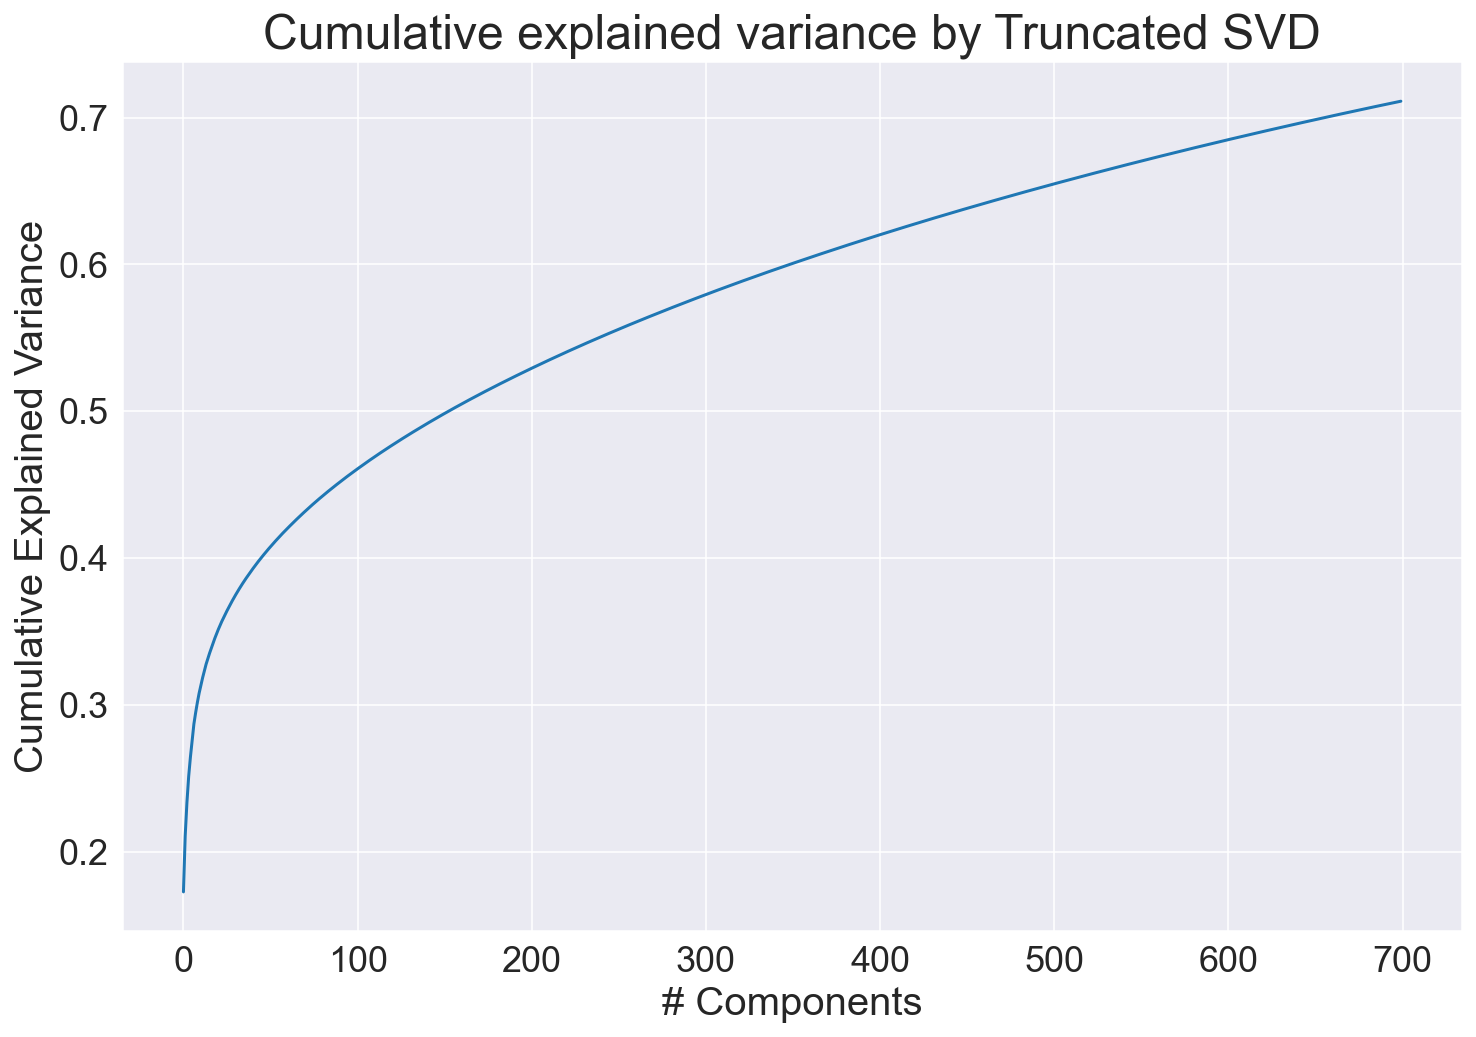

In [39]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('# Components', size=20)
plt.ylabel('Cumulative Explained Variance', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('Cumulative explained variance by Truncated SVD', size=24)
plt.grid(b='both');

#### Now Generate U:

In [40]:
start = time.time()

U, Sigma, VT = randomized_svd(X, 
                              n_components=700,
                              n_iter=20,
                              random_state=42)

end = time.time()

In [41]:
print('Execution time: {} minutes'.format(round((end - start)/60, 2)))

Execution time: 11.21 minutes


In [42]:
save('u_matrix.npy', U)

In [43]:
save('vt_matrix.npy', VT)

In [44]:
del U
del Sigma
del VT

## 4) Recommender

In [45]:
U = load('u_matrix.npy')
U.shape

(50000, 700)

In [46]:
X.shape

(50000, 28044)

In [47]:
movie_ids = load('movie_ids.npy')
movie_ids.shape

(28044,)

In [98]:
def get_idx(user_id, user_ids=user_ids):
    return np.where(user_ids == user_id)[0][0]

In [237]:
# Adapted from Metis Recommender Systems Lecture 5

def user_rec(user_id, user_ids, U, X, movie_ids, movies, 
             ratings_count_df, min_rating=4, how_many=10):
    if ratings_count_df[ratings_count_df['userId'] == user_id]['num_ratings'].values.shape[0] == 0:
        # Too few ratings to match a "similar user" to this user
        return (0, 0)
    users = []
    # Calculate relative similarity with all other users
    for idx in range(U.shape[0]):
        # Don't compute similarity of user_id w/ itself 
        if idx != get_idx(user_id):
            # Only compute for pairs w/ at least 5 previously-rated movies in common
            if np.intersect1d(np.where(X[get_idx(user_id)] > 0)[0], np.where(X[idx] > 0)[0]).shape[0] >= 5:
                # Only compute if user_id hasn't seen all of other user's movies
                if np.where(X[get_idx(user_id)] > 0)[0].shape[0] < np.where(X[idx] > 0)[0].shape[0]:
                    sim = np.dot(U[idx, :], U[get_idx(user_id), :])
                    users.append((idx, sim))
            
    # Sort by degree of similarity and return top user
    users.sort(key=lambda x: x[1], reverse=True)
    if len(users) > 0:
        top_user_id = user_ids[users[0][0]]
    else:
        return (0, 1)
    
    # Compare rated/unrated movies and return user_id's unrated movies from top_user_id's rated movies
    recs = movie_ids[[n for n,val in enumerate(X[get_idx(user_id)]) \
                                    if n in np.where(X[get_idx(top_user_id)] >= min_rating)[0] and val == 0]][0:how_many]
    return (top_user_id, movies[movies['movieId'].isin(recs)])

In [312]:
def recommendations(user_id, user_ids=user_ids, U=U, X=X, movie_ids=movie_ids, movies=movies,
                    ratings_count_df=ratings_count_df, min_rating=4, how_many=10):
    recs = user_rec(user_id, user_ids, U, X, movie_ids, movies, ratings_count_df, min_rating, how_many)
    
    if recs == (0, 0):
        print('\nSorry, the user must have at least 5 previously-rated movies to find similar users.\n')
    elif recs == (0, 1):
        print('\nSorry, User #{} does not have any similar users.\n'.format(user_id))
    else:
        print('\nRecommendations Rated {} or Better Based on Your Rating History \n(Movies Liked by Similar User # {}):\n'
              .format(float(min_rating), recs[0]))
        display(projected_ratings(recs[1], recs[0], X, movie_ids))

In [108]:
def projected_ratings(df, similar_user_id, X, movie_ids):
    dft = df.copy(deep=True).reset_index(drop=True)
    dft['projected_rating'] = 0.0
    for n, row in dft.iterrows():
        dft.iloc[n, 2] = X[get_idx(similar_user_id), np.where(movie_ids == dft.iloc[n, 0])[0][0]]
    return dft

In [317]:
def two_users_overlap(user_id, similar_user_id, movies_df=movies, user_ids=user_ids, X=X, movie_ids=movie_ids):
    common_ratings = np.intersect1d(np.where(X[get_idx(user_id)] > 0)[0], np.where(X[get_idx(similar_user_id)] > 0)[0])
    if common_ratings.shape[0] < 5:
        print('\nSorry, User #{} and User #{} have not rated enough of the same movies and therefore cannot be compared.\n'
              .format(user_id, similar_user_id))
        return None
    df = movies[movies['movieId'].isin(movie_ids[common_ratings])][['title']].reset_index(drop=True)
    df['user_rating'] = X[get_idx(user_id), common_ratings]
    df['similar_user_rating'] = X[get_idx(similar_user_id), common_ratings]
    df['rating_difference'] = df['user_rating'] - df['similar_user_rating']
    print('\nCommon Movie Ratings Between User #{} and Similar User #{}:\n'.format(user_id, similar_user_id))
    display(df)
    print('Mean Absolute Deviation of rating_difference = {}'.format(round(df['rating_difference'].mad(), 1)))

In [238]:
ratings_count_df.head()

,userId,num_ratings
1,2,15
4,5,71
6,7,15
7,8,31
9,10,118


In [225]:
ratings_count_df[ratings_count_df['userId'] == 94843]

,userId,num_ratings
94819,94843,4965


In [313]:
## Get recommendations for User #2 (who has rated 15 movies)

recommendations(user_id=2, min_rating=5)


Recommendations Rated 5.0 or Better Based on Your Rating History 
(Movies Liked by Similar User # 95643):



,movieId,title,projected_rating
0,50,The Usual Suspects,5.0
1,296,Pulp Fiction,5.0
2,318,The Shawshank Redemption,5.0
3,778,Trainspotting,5.0
4,858,The Godfather,5.0
5,1193,One Flew Over the Cuckoo's Nest,5.0
6,1617,L.A. Confidential,5.0
7,2858,American Beauty,5.0
8,2959,Fight Club,5.0
9,4011,Snatch,5.0


In [318]:
two_users_overlap(user_id=2, similar_user_id=95643)


Common Movie Ratings Between User #2 and Similar User #95643:



,title,user_rating,similar_user_rating,rating_difference
0,Hackers,3.5,3.5,0.0
1,"Sex, Lies, and Videotape",3.5,4.0,-0.5
2,Harold and Maude,3.0,5.0,-2.0
3,Manhattan,3.0,4.5,-1.5
4,A Room with a View,4.5,5.0,-0.5
5,Stripes,3.0,4.5,-1.5
6,Driving Miss Daisy,4.0,4.5,-0.5
7,L.A. Story,3.5,5.0,-1.5
8,The Big Chill,4.0,4.5,-0.5
9,Little Shop of Horrors,4.0,4.5,-0.5


Mean Absolute Deviation of rating_difference = 0.5


In [319]:
## Get recommendations for User #5 (who has rated 71 movies)

recommendations(user_id=5, min_rating=4)


Recommendations Rated 4.0 or Better Based on Your Rating History 
(Movies Liked by Similar User # 5403):



,movieId,title,projected_rating
0,32,Twelve Monkeys,4.5
1,111,Taxi Driver,4.5
2,356,Forrest Gump,4.5
3,608,Fargo,4.5
4,750,Dr. Strangelove or: How I Learned to Stop Worr...,4.5
5,908,North by Northwest,5.0
6,1057,Everyone Says I Love You,4.5
7,1206,A Clockwork Orange,4.0
8,1230,Annie Hall,5.0
9,1416,Evita,4.0


In [320]:
two_users_overlap(user_id=5, similar_user_id=5403)


Common Movie Ratings Between User #5 and Similar User #5403:



,title,user_rating,similar_user_rating,rating_difference
0,Pulp Fiction,5.0,5.0,0.0
1,The Shawshank Redemption,5.0,4.5,0.5
2,Schindler's List,4.5,4.5,0.0
3,Trainspotting,5.0,5.0,0.0
4,One Flew Over the Cuckoo's Nest,4.0,4.5,-0.5
...,...,...,...,...
28,Gone Baby Gone,4.0,4.0,0.0
29,American Gangster,4.0,4.5,-0.5
30,No Country for Old Men,4.5,4.5,0.0
31,Juno,5.0,5.0,0.0


Mean Absolute Deviation of rating_difference = 0.4


In [321]:
## Get recommendations for User #10 (who has rated 118 movies)

recommendations(user_id=10, min_rating=3)


Recommendations Rated 3.0 or Better Based on Your Rating History 
(Movies Liked by Similar User # 29739):



,movieId,title,projected_rating
0,293,Léon: The Professional,4.5
1,296,Pulp Fiction,5.0
2,858,The Godfather,5.0
3,1222,Full Metal Jacket,4.0
4,1235,Harold and Maude,4.0
5,1617,L.A. Confidential,5.0
6,2108,L.A. Story,4.0
7,2329,American History X,5.0
8,2502,Office Space,4.5
9,2858,American Beauty,4.5


In [322]:
two_users_overlap(user_id=10, similar_user_id=29739)


Common Movie Ratings Between User #10 and Similar User #29739:



,title,user_rating,similar_user_rating,rating_difference
0,Toy Story,5.0,4.5,0.5
1,Twelve Monkeys,4.0,4.0,0.0
2,Se7en,5.0,5.0,0.0
3,The Usual Suspects,4.0,4.0,0.0
4,Taxi Driver,5.0,5.0,0.0
...,...,...,...,...
70,The World Is Not Enough,3.0,4.0,-1.0
71,All About My Mother,5.0,4.5,0.5
72,Dead Calm,3.0,4.0,-1.0
73,Wayne's World,3.0,3.5,-0.5


Mean Absolute Deviation of rating_difference = 0.6


In [328]:
## Get recommendations for User #41 (who has rated fewer than 5 movies)

recommendations(41, user_ids, U, X, movie_ids, movies, ratings_count_df, min_rating=5)


Sorry, the user must have at least 5 previously-rated movies to find similar users.



In [323]:
## Get recommendations for User #94843 (who has rated 4965 movies - more than any other user in the final users_ratings_matrix)

recommendations(user_id=94843, min_rating=3)


Sorry, User #94843 does not have any similar users.



In [324]:
two_users_overlap(user_id=44276, similar_user_id=105056)


Sorry, User #44276 and User #105056 have not rated enough of the same movies and therefore cannot be compared.

